In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## IMPORTS 
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import random 
import torch
import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T

#import torchvision
#from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


#import splitfolders
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import glob
import time
import PIL
from PIL import Image
import os
import cv2
import timm

In [ ]:
## IMPORTING THE MIDAS NETWORK

#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [ ]:
## COMPUTATIONAL RESSOURCES 

!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# Activate cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [ ]:
## GHOST CITY MODEL

# Original images 
#full_data_path='/content/drive/MyDrive/ghost_city_model/images'
#output_images='/content/drive/MyDrive/ghost_city_model/images_split'

#Associated depth maps
#full_depth_maps_path = '/content/drive/MyDrive/ghost_city_model/depth_maps'
#output_depth_maps='/content/drive/MyDrive/ghost_city_model/depth_maps_split'


In [ ]:
## MEDIUM STRUCTURE MODEL

# Original images 
full_data_path='/content/drive/MyDrive/medium_structure_model/images_resized_256/class0'


#Associated depth maps
full_depth_maps_path = '/content/drive/MyDrive/medium_structure_model/depth_maps_resized_256/class0'


In [ ]:
#LOADING DATA

def load_data(data_path, verbose=False):
    DATA_LOADED=False 
    print_every_n_loads=10
    images=[]
    ind=0
    t0=time.time()
    if not DATA_LOADED:
      print('Loading data...')
      list_dir = os.listdir(data_path)
      list_dir=sorted(list_dir, key=lambda x: x.lower())
      for filename in list_dir:
          if ind<5:
            print(str(filename))
          img = mpimg.imread(os.path.join(data_path, filename))
          if img is not None:
              images.append(np.asarray(img))
              ind+=1
          if verbose:
              if ind%print_every_n_loads==0:
                  print('nb of data loaded:', ind)
      print(f'Loaded data in: {time.time()-t0 } s')
    return images

images=load_data(full_data_path)
depth_maps=load_data(full_depth_maps_path)

Loading data...
resized_256_20220514T001442.000Z.jpg
resized_256_20220514T001444.000Z.jpg
resized_256_20220514T001446.000Z.jpg
resized_256_20220514T001448.000Z.jpg
resized_256_20220514T001450.000Z.jpg
Loaded data in: 0.602165937423706 s
Loading data...
resized_256_depth_20220514T001442.000Z.png
resized_256_depth_20220514T001444.000Z.png
resized_256_depth_20220514T001446.000Z.png
resized_256_depth_20220514T001448.000Z.png
resized_256_depth_20220514T001450.000Z.png
Loaded data in: 0.7254495620727539 s


In [ ]:
DATA_LOADED=True
#NUM_TRAIN=len(train_images)
#NUM_VAL=len(val_images)
#NUM_TEST=len(test_images)
#H, W, C=train_images[0].shape
#print(NUM_TRAIN, NUM_VAL, NUM_TEST)
SCALE_FACTOR=1000 #Need to increaze the really small values in the depth_maps data,
# otherwise, during transformation, all elements are set to zero.

In [ ]:
## Using different metrics to evaluate performances of the network

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

#A loss robust to outliers + large data values 

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(torch.abs(pred + 1)), torch.log(torch.abs(actual + 10))))

In [ ]:
class Original_and_Depth_Map(torch.utils.data.Dataset):

    def __init__(self, datasetA, datasetB, transform=None):
        self.datasetA = np.array(datasetA).astype(np.uint8)
        self.datasetB = (np.array(datasetB)*1000).astype(np.uint8)
        self.transform= transform
        #self.meanA, self.stdA=get_mean_std(datasetA)
        #self.meanB, self.stdB=get_mean_std(datasetB)
        #self.transformA = T.Compose([T.ToTensor()
       #, T.Normalize(self.meanA, self.stdA)
        #])
        #self.transformB=T.ToTensor()
        #self.transformB = T.Compose([  T.ToTensor(), T.Normalize(self.meanB, self.stdB),
       #])
    

        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]

        if self.transform:
          return self.transform(xA), self.transform(xB)
        
        return xA, xB

    def __len__(self):
        return len(self.datasetA)

In [ ]:
# LOADING THE NECESSARY MIDAS TRANSFORM

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform_midas = midas_transforms.dpt_transform
else:
    transform_midas = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
#

In [ ]:
batch_size = 2

# CREATING THE TRAIN VAL AND TEST DATASETS

full_dataset =Original_and_Depth_Map(images, depth_maps)
train_and_eval_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_and_eval_size
train_and_eval, test_dataset = torch.utils.data.random_split(full_dataset, [train_and_eval_size, test_size])

train_size= int(0.9 * len(train_and_eval))
val_size = len(train_and_eval) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_and_eval, [train_size, val_size])

#DATALOADERS
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
#LENGHT TEST 

print(len(train_dataset), len(test_dataset), len(val_dataset))

85 11 10


In [ ]:
#APPLYING THE NECESSARY TRANSFORMATION TO ALL IMAGES OF THE DATASET
#for image, depthmap in train_loader:
  #for im in image:
    #im = transform_midas(im.numpy())
    #im=torch.from_numpy(np.reshape(im.numpy().astype(np.uint8), (224,384,3)))


#print(im.size())

70


<Figure size 432x288 with 0 Axes>

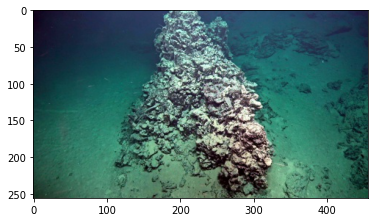

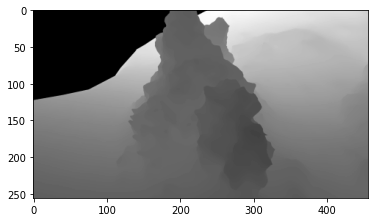

<Figure size 432x288 with 0 Axes>

In [ ]:
ind=np.random.randint(105)
print(ind)
plt.imshow(full_dataset[ind][0])
plt.figure()
plt.imshow(full_dataset[ind][1], cmap='gray')
plt.figure()
#ORDRE OK!!

cpu
output size torch.Size([1, 128, 256])
original depth map size torch.Size([256, 456])
tensor(2.1197, grad_fn=<SqrtBackward0>)


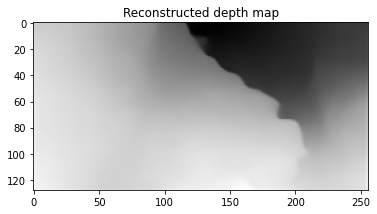

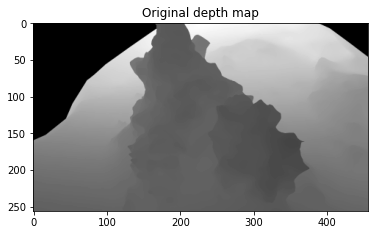

<Figure size 432x288 with 0 Axes>

In [ ]:
#CHECKING THAT THE FORWARD FUNCTION WORKS OK, STEP BY STEP
midas.to(device)
loss_function=RMSLELoss()
print(device)

for image, depth in train_loader:
  #print(image.size())
  #print(depth.size()
  #midas.train()
  depth.to(device)
  for im, d in zip(image, depth):
    im=transform_midas(im.numpy()).to(device)
    output=midas(im).to(device)
    
    print('output size', output.size())
    plt.imshow(output.cpu().detach().squeeze().numpy(), cmap='gray')
    plt.title('Reconstructed depth map')
    plt.figure()
    plt.title('Original depth map')
    plt.imshow(depth[0],cmap='gray')
    plt.figure()
    print('original depth map size', d.size())
    loss=loss_function(output.squeeze(), d[:128, :256])
    print(loss)
    break
  break


In [ ]:
for image, _ in train_loader:
  for im in image:
    print('Before transformation')
    print(im.size())
    print(im[0][0])
    im=transform_midas(im.numpy()).to(device)
    print('After transformation')
    print(im.size())
    print(im[0][0])
    break
  break


#Applying the transformation works -> the image is resized and set to the batch shape, ready to be taken by the network.

Before transformation
torch.Size([256, 456, 3])
tensor([11,  0, 13], dtype=torch.uint8)
After transformation
torch.Size([1, 3, 128, 256])
tensor([[-1.9060, -1.9247, -1.8860,  ..., -1.8137, -1.8467, -1.8695],
        [-1.9742, -1.9473, -1.9443,  ..., -1.7500, -1.7635, -1.8387],
        [-1.7699, -2.0005, -1.9906,  ..., -1.8637, -1.8389, -1.8302],
        ...,
        [-1.4717, -1.4102, -1.3334,  ..., -1.4162, -1.3176, -1.3678],
        [-1.4425, -1.4842, -1.4348,  ..., -1.3639, -1.9869, -1.4249],
        [-1.4969, -1.5203, -1.5489,  ..., -1.0821, -1.1012, -1.6062]])


In [ ]:
for image, _ in train_loader:
  for im in image:
    im=transform_midas(im.numpy()).to(device)

#Transformation applied to all images 

In [ ]:
#Understanding the size problem which just popped up yay

In [ ]:
#Training function

def train_epoch(network, device, dataloader, optimizer, loss_function, print_every = 1):
    """ Trains the simple model for one epoch. losses_resolution indicates how often training_loss should be printed and stored. """
    network.train()
    network.to(device)
    train_losses = []
    
    # Iterate the dataloader (We do not need the label value which is 0 here, the depth maps are the labels)
    iter = 0
    for image, depth_map in dataloader:   
      #Moving to GPU
      image.to(device)
      d = depth_map.to(device)

      #Applying the necessary transforms
      #(transform_midas does not keep the transformations in memory of the dataloader.)
      #Best= apply it the the entire dataset in its definition
      image=np.transpose(image, [0,3,1,2])
      image = image.type(torch.FloatTensor)
      image=T.functional.resize(image, (128, 256))
      d=d.type(torch.FloatTensor)


      #Going through the network
      d_hat = network(image)
    

      #Computing the loss, storing it
      d_test=T.functional.resize(d, (128, 256))
      loss=loss_function(d_hat.squeeze(),  d_test).float()
      
      # Backward pass
      optimizer.zero_grad()  # Sets the gradients attached to the parameters objects to zero.
      loss.backward()  # Uses the gradient object attached to the loss to recursively compute the gradients of the parameters of the network (and store their value in the gradient objects attached to said parameters)
      optimizer.step()  # Actually chages the values of the parameters using their gradients, computed on the previous line of code.
      
      # Print and store batch loss
      batch_loss = loss.item()/d.shape[0]
      train_losses.append(batch_loss)
        
        #Display
        #if iter%print_every == 0:
            #print(f'\t partial train loss (single batch): {batch_loss:.2f}')
    return train_losses


In [ ]:
#First try training loop OK
mse= nn.MSELoss()
rmse=RMSELoss()
lr=1e-3
weight_decay=1e-4
optim= torch.optim.Adam(midas.parameters(), lr=lr, weight_decay=weight_decay)

#train_losses_epoch = train_epoch(midas, device, train_loader,optim, mse)

In [ ]:
# Trying to get a grasp on the model:

# Print model's state_dict: What is going on inside our model?
print("Model's state_dict:")
for param_tensor in midas.state_dict():
    print(param_tensor, "\t", midas.state_dict()[param_tensor].size())

Model's state_dict:
pretrained.layer1.0.weight 	 torch.Size([32, 3, 3, 3])
pretrained.layer1.1.weight 	 torch.Size([32])
pretrained.layer1.1.bias 	 torch.Size([32])
pretrained.layer1.1.running_mean 	 torch.Size([32])
pretrained.layer1.1.running_var 	 torch.Size([32])
pretrained.layer1.1.num_batches_tracked 	 torch.Size([])
pretrained.layer1.3.0.conv_dw.weight 	 torch.Size([32, 1, 3, 3])
pretrained.layer1.3.0.bn1.weight 	 torch.Size([32])
pretrained.layer1.3.0.bn1.bias 	 torch.Size([32])
pretrained.layer1.3.0.bn1.running_mean 	 torch.Size([32])
pretrained.layer1.3.0.bn1.running_var 	 torch.Size([32])
pretrained.layer1.3.0.bn1.num_batches_tracked 	 torch.Size([])
pretrained.layer1.3.0.conv_pw.weight 	 torch.Size([24, 32, 1, 1])
pretrained.layer1.3.0.bn2.weight 	 torch.Size([24])
pretrained.layer1.3.0.bn2.bias 	 torch.Size([24])
pretrained.layer1.3.0.bn2.running_mean 	 torch.Size([24])
pretrained.layer1.3.0.bn2.running_var 	 torch.Size([24])
pretrained.layer1.3.0.bn2.num_batches_tracked 	

In [ ]:
## Testing function

def validation_epoch(network, device, loss_function, dataloader):
    "Set evaluation mode for encoder and decoder"
    network.to(device)
    network.eval()  # evaluation mode, equivalent to "network.train(False)""
    val_loss = 0
    with torch.no_grad(): # No need to track the gradients
        for image, depth_map in dataloader:
            #Moving to GPU
            image.to(device)
            d = depth_map.to(device)

            #Applying the necessary transforms
            #(transform_midas does not keep the transformations in memory of the dataloader.)
            #Best= apply it the the entire dataset in its definition
            image=np.transpose(image, [0,3,1,2])
            image = image.type(torch.FloatTensor)
            image=T.functional.resize(image, (128, 256))
            d=d.type(torch.FloatTensor)


            #Going through the network
            d_hat = network(image)
          

            #Computing the loss, storing it
            d_test=T.functional.resize(d, (128, 256))
            loss=loss_function(d_hat.squeeze(),  d_test).float()
            val_loss += loss.item()/d.shape[0]

    return val_loss/len(dataloader)


In [ ]:
#Plotting the learning and validation loss curves


def plot_learning_curves(train_losses, val_losses):
    """ Plots the learning curve. Losses resolution (how many times the loss is displayed) is one value per batch for the training losses, and one value per epoch for the validation. """
    iterations_train = np.arange(0, batch_size*train_losses.size, batch_size)
    iterations_validation = np.arange(0, train_size*val_losses.size, train_size)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(iterations_train, train_losses, color="blue", label="training loss")
    ax.plot(iterations_validation, val_losses/1e6, color="orange", label = "validation loss")
    ax.set(xlabel="iterations", ylabel="loss", title="Training and validation losses over iterations")
    ax.grid()
    ax.legend()

    fig.show()

In [ ]:
a=torch.Tensor([4,5,6,7,8,9])
b=np.reciprocal(a)
print(b)

tensor([0.2500, 0.2000, 0.1667, 0.1429, 0.1250, 0.1111])


In [33]:
## Plotting function

def plot__outputs(network, number_outputs=5, random_plots=True, indices=None, title=None):
  """
    When random_plots = True, different images are taken between each epoch.
    When random_plots = False, indices indicates what images to plot
  """
  fig = plt.figure(figsize=(5*number_outputs,8.5))
  if title is not None:
    fig.suptitle(f'Results at the end of epoch {title}',  fontsize='large', fontweight='bold')
  
  #Selection of random images to plot within the dataset or a select set of indices
  if random_plots:
      plotted_samples = np.random.choice(test_size, number_outputs)
  else:
      plotted_samples = indices
  
  for i in range(number_outputs):
      ax = plt.subplot(3, number_outputs, i+1)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # plt.subplot(nb_rows, nb_cols, num)  where num is indexed from 1
      image = test_dataset[plotted_samples[i]][0]
      plt.imshow(image)
      
      #image = next(iter(test_loader))
      network.train()
      
      with torch.no_grad():
        
        #NECESSARY TRANSFORMS
        np.transpose(image, [2,0,1])
        transform=T.ToTensor()
        image=transform(image)
        image=T.functional.resize(image, (128, 256))
        image = image.type(torch.FloatTensor)
        image=image.unsqueeze(0).to(device)
        output_img  = network(image)

      #right_size_im=np.transpose(im.cpu().squeeze().numpy(), (1, 2, 0))
      #plt.imshow(right_size_im*255)
      plt.imshow(test_dataset[plotted_samples[i]][0])
      if i == number_outputs//2:
          ax.set_title('Original images')
    
      

      ax = plt.subplot(3, number_outputs, i + 1 + number_outputs)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(output_img.cpu().squeeze().numpy(), cmap='gray')
      if i == number_outputs//2:
          ax.set_title('Reconstructed depth maps')
      
      ax=plt.subplot(3, number_outputs, i + 1 + 2*number_outputs)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      #plt.imshow(test_dataset[plotted_samples[i]][1], cmap='gray')
      plt.imshow(test_dataset[plotted_samples[i]][1], cmap='gray')
      if i == number_outputs//2:
          ax.set_title('Original depth maps')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 128, 256])) that is different to the input size (torch.Size([128, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 EPOCH 1/5 	 train loss 261.286 	 val loss 0.501

 EPOCH 2/5 	 train loss 113.545 	 val loss 0.427

 EPOCH 3/5 	 train loss 162.079 	 val loss 0.429

 EPOCH 4/5 	 train loss 119.121 	 val loss 0.428

 EPOCH 5/5 	 train loss 244.153 	 val loss 0.449


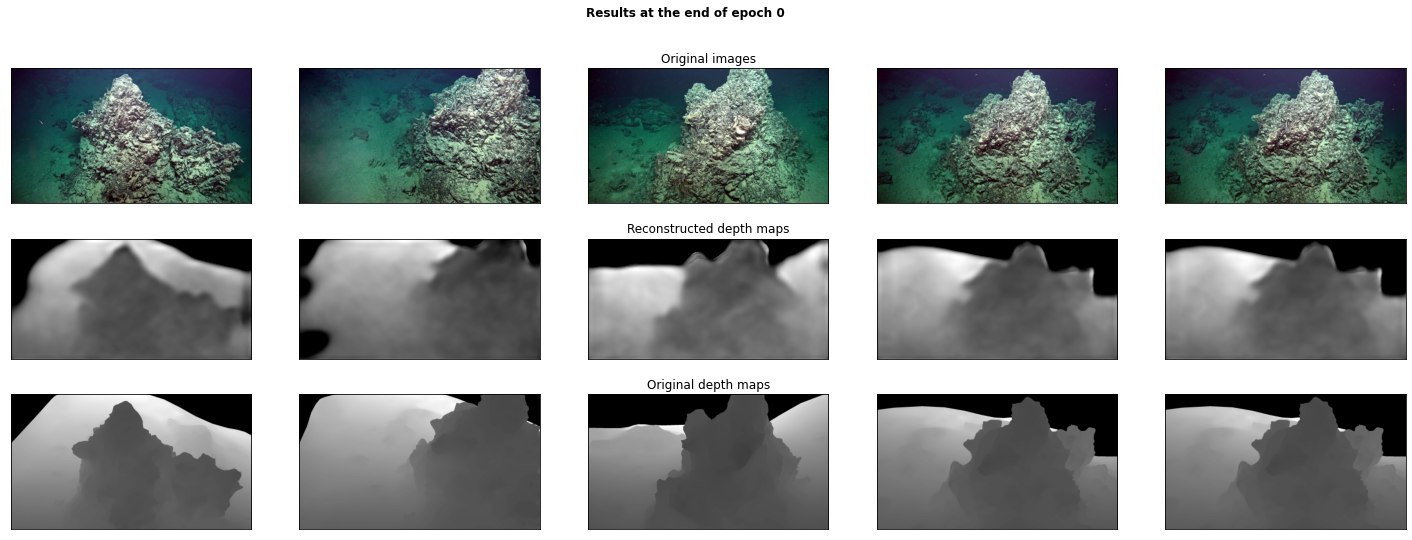

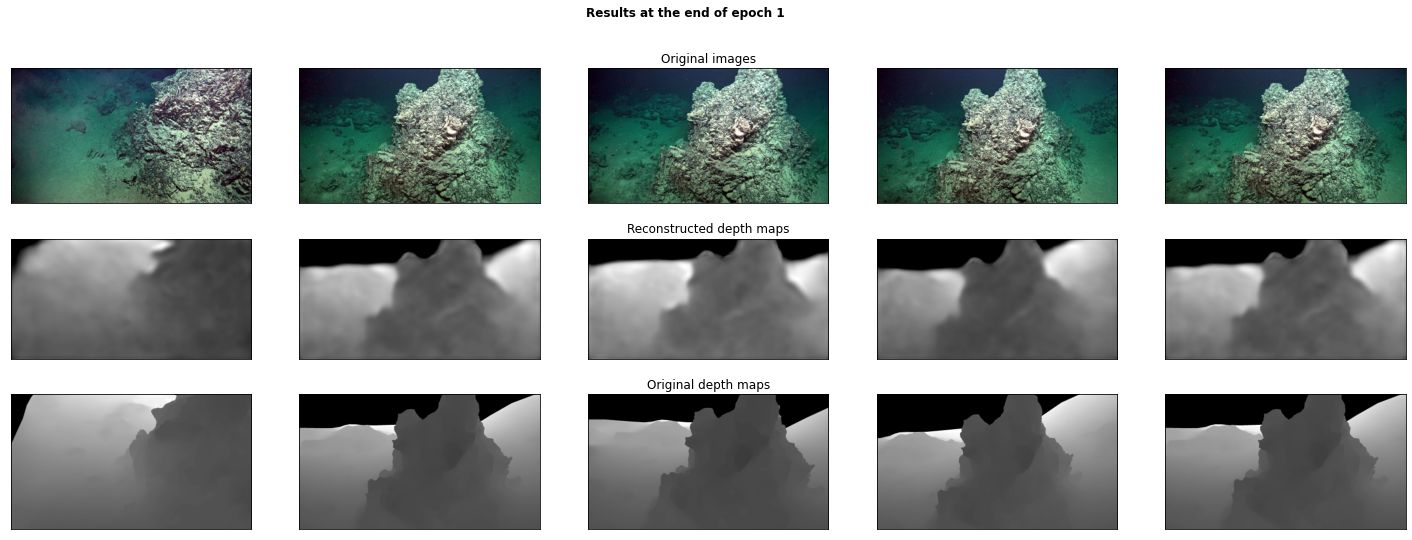

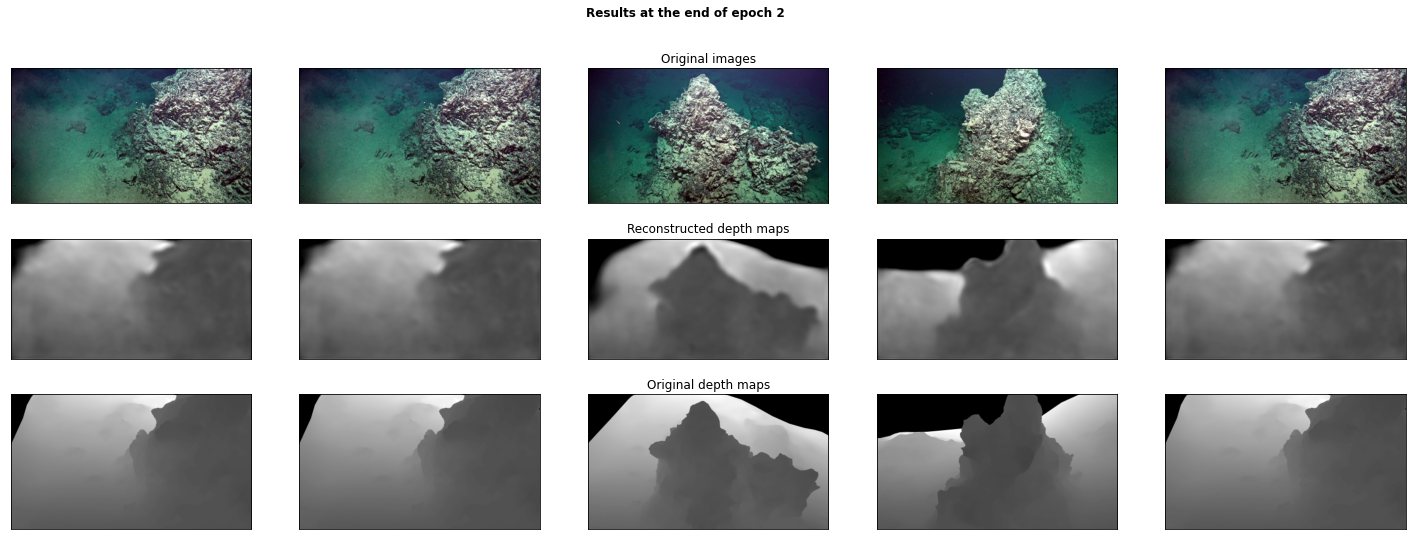

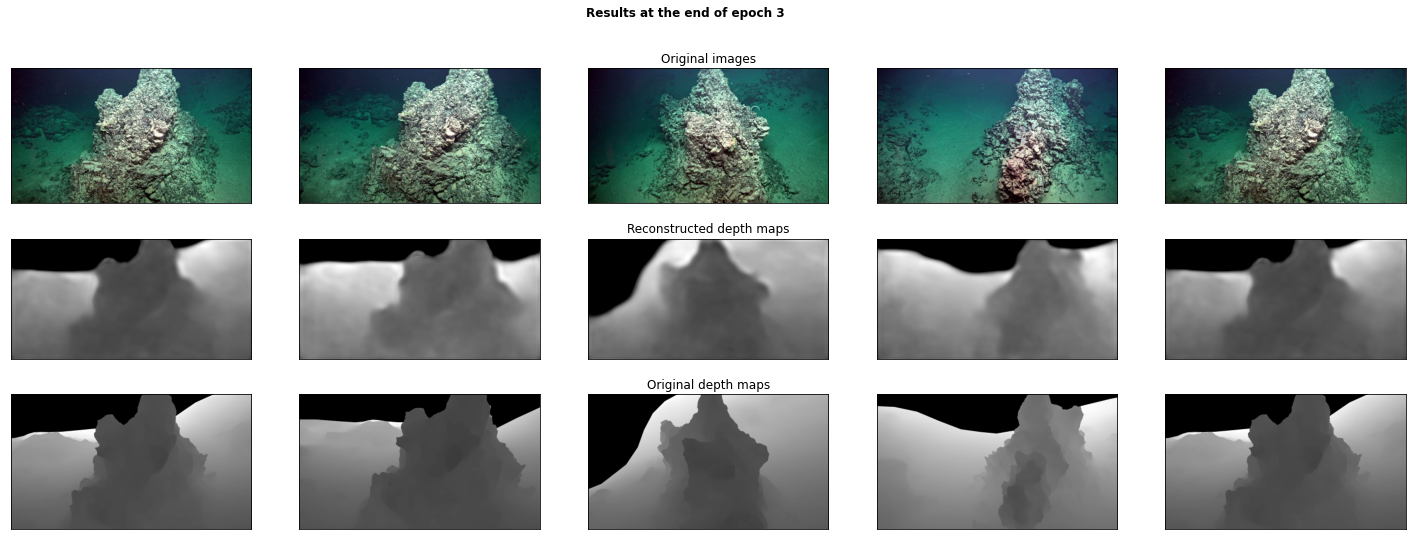

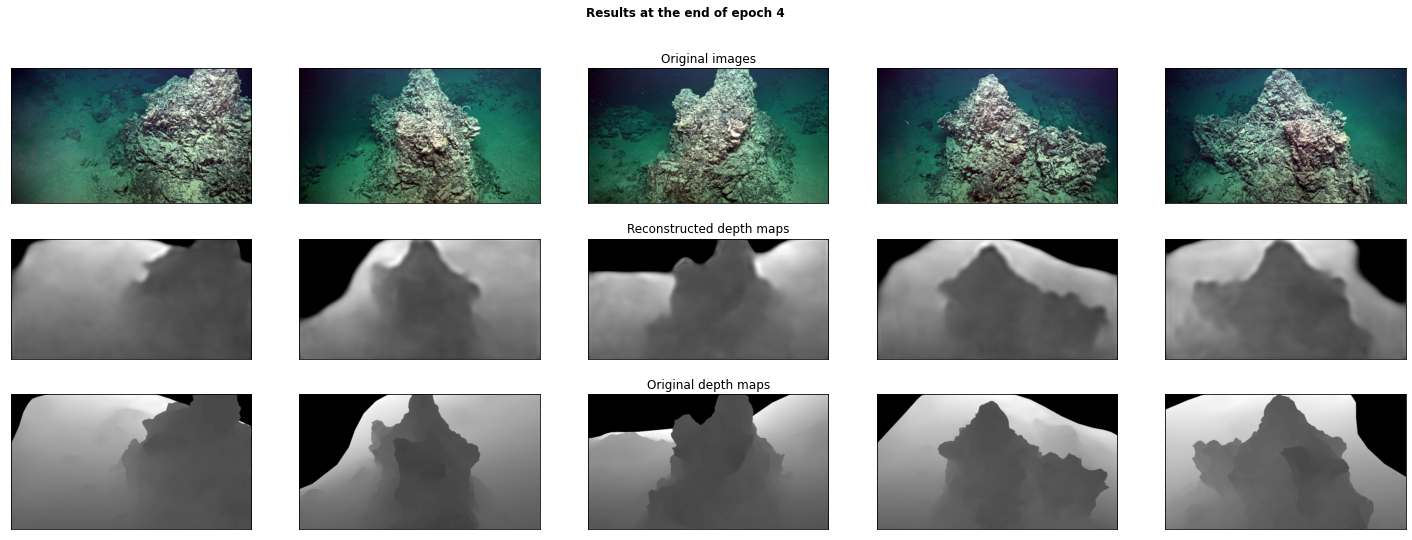

In [35]:
## Training and Validation processes


## Choice of different parameters
lr=1e-3
weight_decay=1e-4 #Weight regularization to avoid overfitting
number_of_plotted_images = 5
plot_images_every_n_epochs = 2
random_plots = True
indices_to_plot = np.arange(number_of_plotted_images)
num_epochs= 5
optim=torch.optim.Adam(midas.parameters(), lr=lr, weight_decay=weight_decay)

## Choice of the loss
mse=nn.MSELoss()
rmse=RMSELoss()
rmsle=RMSLELoss()


train_losses = np.array([])
val_losses = np.array([validation_epoch(midas, device, mse, val_loader)])


## Training process

for epoch in range(num_epochs):
   train_losses_epoch = train_epoch(midas, device, train_loader,optim, mse)
   val_loss_epoch = validation_epoch(midas, device, rmsle, val_loader)
   train_losses = np.concatenate((train_losses, train_losses_epoch))
   val_losses = np.append(val_losses, val_loss_epoch)
   print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_losses_epoch[-1]:.3f} \t val loss {val_loss_epoch:.3f}')

   #Plotting reconstruction results at the end of each epoch to see the evolution
   plot__outputs(midas, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot, title=epoch)


#Plotting 5 images at the end of the reconstruction
# To see the evolution of the reconstruction, integrate in the for loop.

#plot_ae_outputs(midas, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot)

In reality I had already done 10 epochs before plotting the images so the images you see here are from the 10th epoch to the 15th.

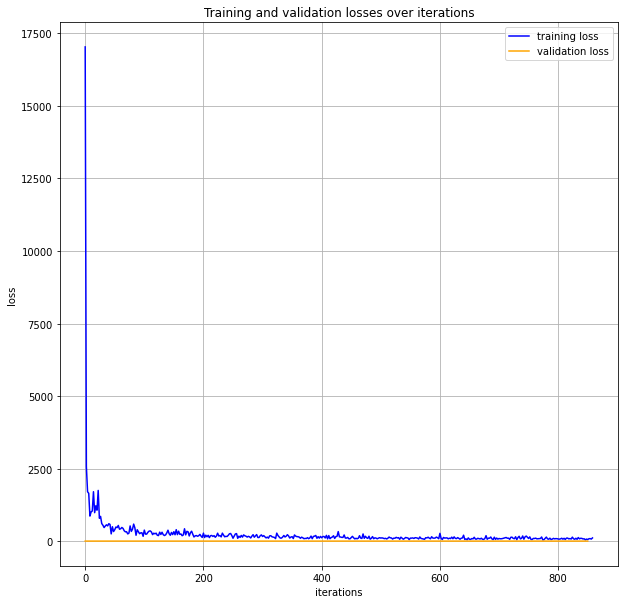

In [ ]:
# Losses with medium_structure_model
plot_learning_curves(train_losses, val_losses)


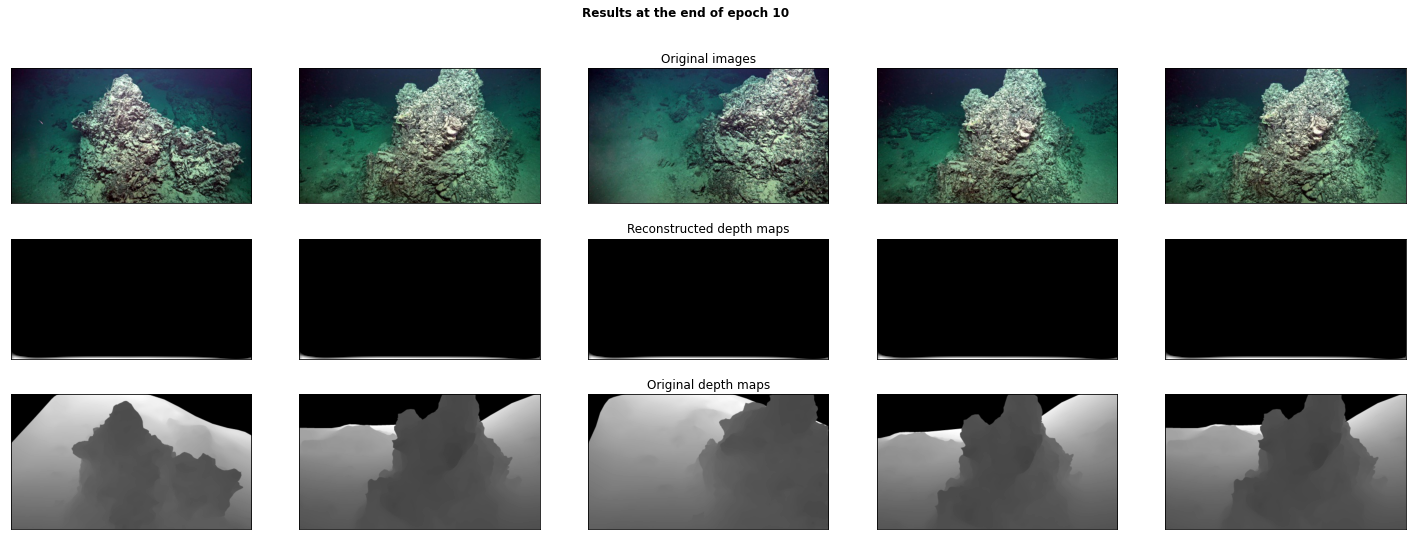

In [ ]:
plot__outputs(midas, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot, title=10)